# Chip Orientation Reference

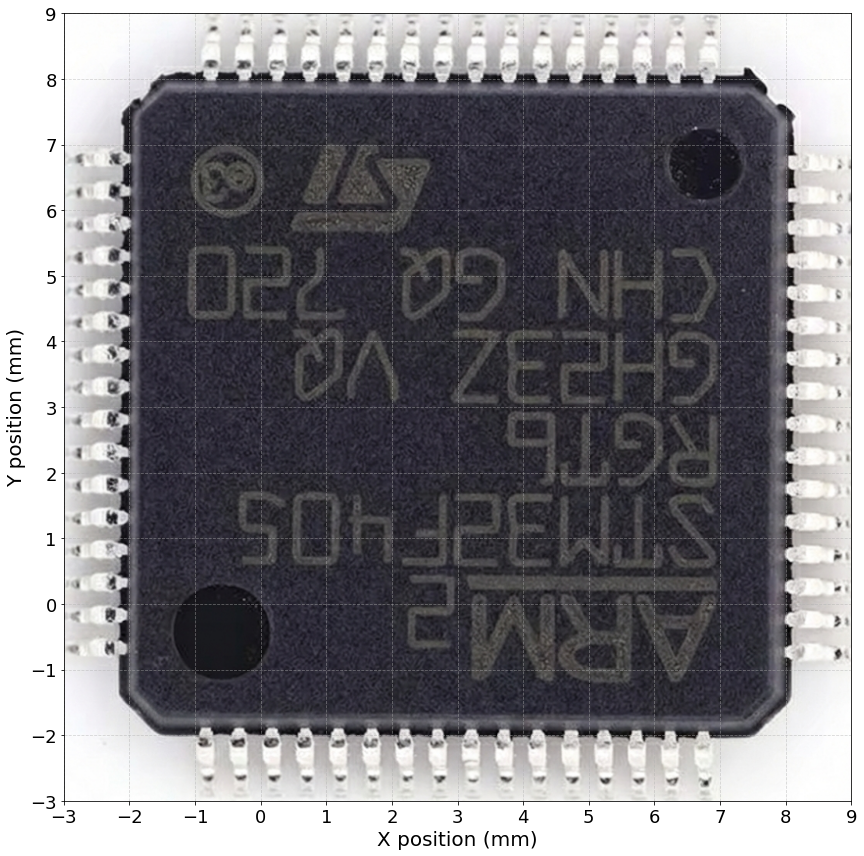

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import json

BG_PATH = "./results/paper-images/chip-package.png"
# TODO: replace image with own or free image of STM32F415

# Load image
bg = plt.imread(BG_PATH)
bg = np.rot90(bg, k=2)

fig, ax = plt.subplots(figsize=(12, 12))

# Set axes limits 0–12
ax.set_xlim(-3, 9)
ax.set_ylim(-3, 9)

# Display image scaled to fit 0–12 range
ax.imshow(
    bg,
    extent=[-3, 9, -3, 9],
    origin="upper",
    aspect="equal"  # preserve aspect ratio of image
)

# Axes labels and ticks with larger font
ax.set_xlabel("X position (mm)", fontsize=20)
ax.set_ylabel("Y position (mm)", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_xticks(np.arange(-3, 10, 1))  # 0,1,2,...12
ax.set_yticks(np.arange(-3, 10, 1))

# Optional: show grid for better reference
ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


# Profile Memcpy

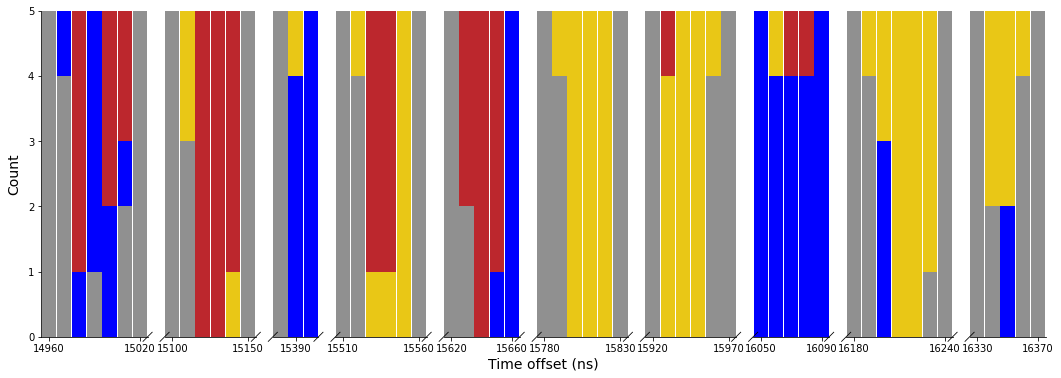

In [22]:
from brokenaxes import brokenaxes
import matplotlib.pyplot as plt
import numpy as np


JSON_PATH = './results/results_profile-memcpy.json'

with open(JSON_PATH, 'r') as f:
    data = json.load(f)

# Prepare arrays
time_offsets = np.array([cfg["pulse_offset"] for cfg in data["glitch_configs"]][:150])
num_nofaults = np.array([cfg["results"]["num_nofaults"][0] for cfg in data["glitch_configs"]][:150])
num_crashes = np.array([cfg["results"]["num_crashes"][0] for cfg in data["glitch_configs"]][:150])
num_skipped = []
num_corrupted = []

focus_regions = []

for cfg in data["glitch_configs"][:150]:
    if cfg["results"]["num_faults"][0] > 0:
        fault_data = cfg["results"]["faults"][0]["data"]

        skipped_count = sum(1 for fd in fault_data if fd["target_buffer"] and set(fd["target_buffer"]) == {"E"})
        num_skipped.append(skipped_count)

        corrupted_count = len(fault_data) - skipped_count
        num_corrupted.append(corrupted_count)

        if skipped_count > 0 or corrupted_count > 0:
            focus_regions.append([cfg["pulse_offset"] - 10, cfg["pulse_offset"] + 10])
    else:
        num_skipped.append(0)
        num_corrupted.append(0)

num_skipped = np.array(num_skipped)
num_corrupted = np.array(num_corrupted)

# Merge close focus regions
focus_regions.sort()
merged = []
for start, end in focus_regions:
    if not merged:
        merged.append([start-15, end+5])
    else:
        prev_start, prev_end = merged[-1]
        if start <= prev_end+15:  # distance < 10
            merged[-1][1] = max(end+5, prev_end)
        else:
            merged.append([start-5, end+5])
focus_regions = merged

# Filter data to only focus regions
mask = np.zeros_like(time_offsets, dtype=bool)
for start, end in focus_regions:
    mask |= (time_offsets >= start) & (time_offsets <= end)

time_offsets_plot = time_offsets[mask]
num_nofaults_plot = num_nofaults[mask]
num_crashes_plot = num_crashes[mask]
num_skipped_plot = num_skipped[mask]
num_corrupted_plot = num_corrupted[mask]

# First create a figure with the desired size
fig = plt.figure(figsize=(18, 6))

# Pass the figure to brokenaxes
bax = brokenaxes(xlims=focus_regions, hspace=0.06, figure=fig, d=0.005)

# Compute bar width
if len(time_offsets_plot) > 1:
    dx = np.diff(np.sort(time_offsets_plot)).min()
else:
    dx = 1
bar_width = dx * 0.95

# Plot stacked bars
bax.bar(time_offsets_plot, num_nofaults_plot, width=bar_width, color='#909090', label='unfaulted') # #50AD9FFF
bax.bar(time_offsets_plot, num_crashes_plot, width=bar_width, bottom=num_nofaults_plot, color='#0000ff', label='target unresponsive')
bax.bar(time_offsets_plot, num_skipped_plot, width=bar_width, bottom=num_nofaults_plot+num_crashes_plot+num_corrupted_plot, color='#bc272d', label='memcpy fully skipped')
bax.bar(time_offsets_plot, num_corrupted_plot, width=bar_width, bottom=num_nofaults_plot+num_crashes_plot, color='#e9c716', label='partly skipped / corrupted')

# Labels
bax.set_xlabel("Time offset (ns)", fontsize=14, labelpad=20)  # 12 points of padding
bax.set_ylabel("Count", fontsize=14, labelpad=20)

# For each sub-axes in brokenaxes
for ax, (start, end) in zip(bax.axs, focus_regions):
    if (end - start) < 50:
        ax.set_xticks([start+15])
        ax.set_xticklabels([str(int(start+15))])
    else:
        ax.set_xticks([start+5, end-5])
        ax.set_xticklabels([str(int(start+5)), str(int(end-5))])


# bax.legend()
plt.show()


# Profile Counter

49


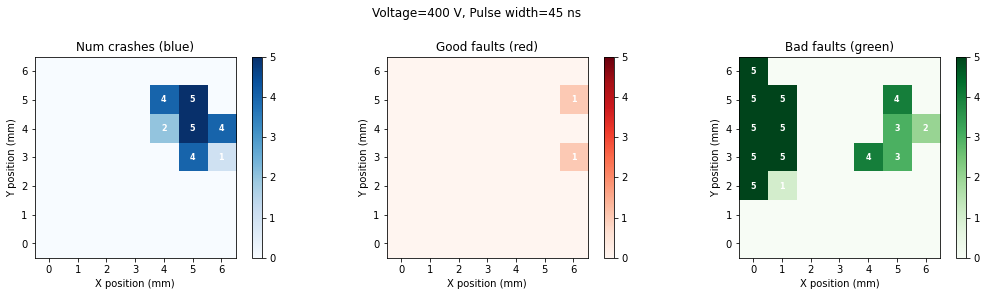

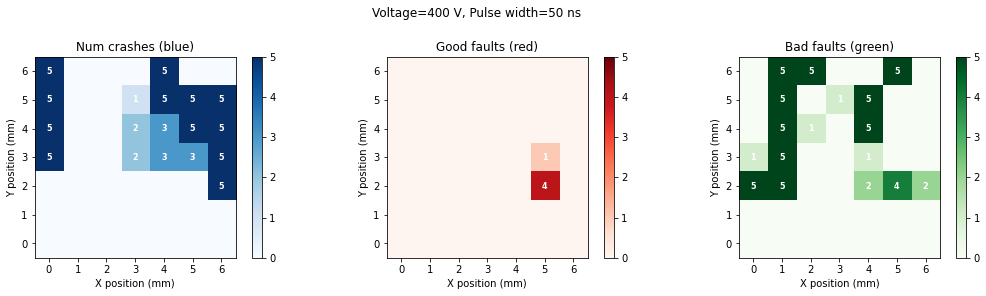

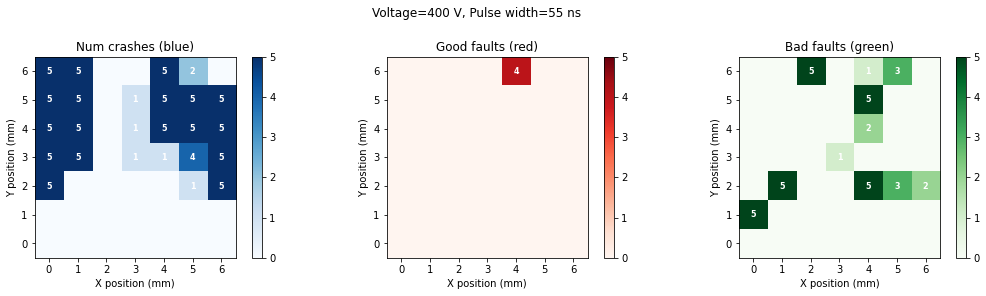

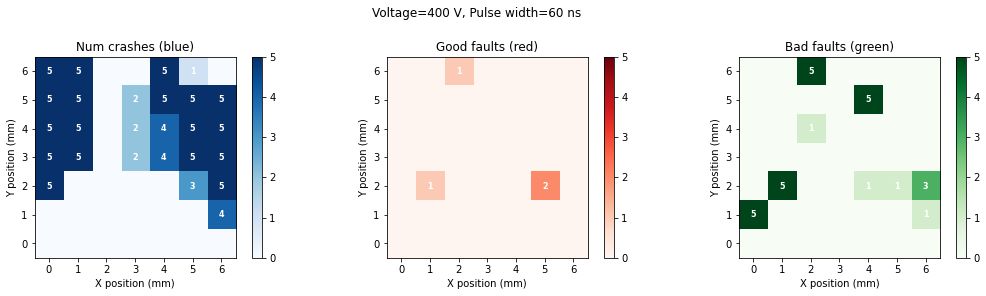

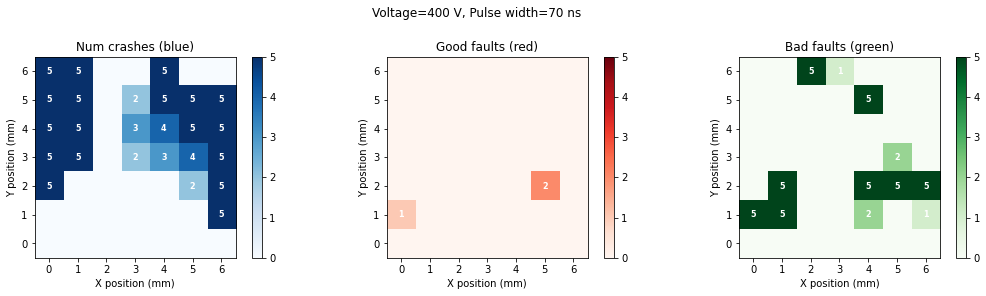

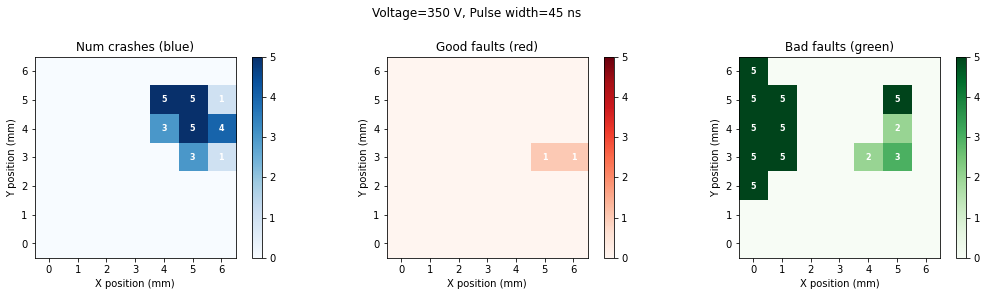

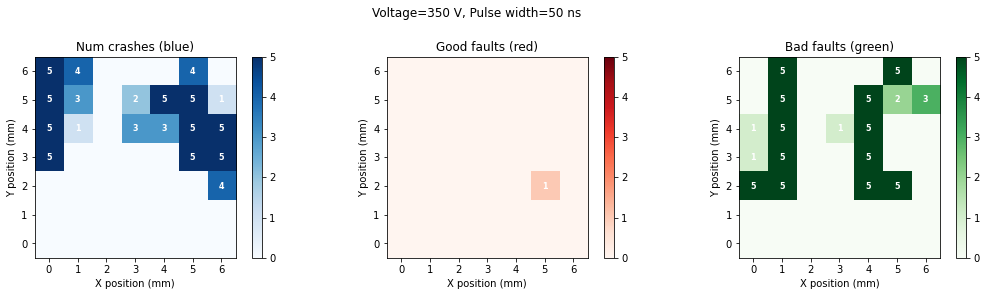

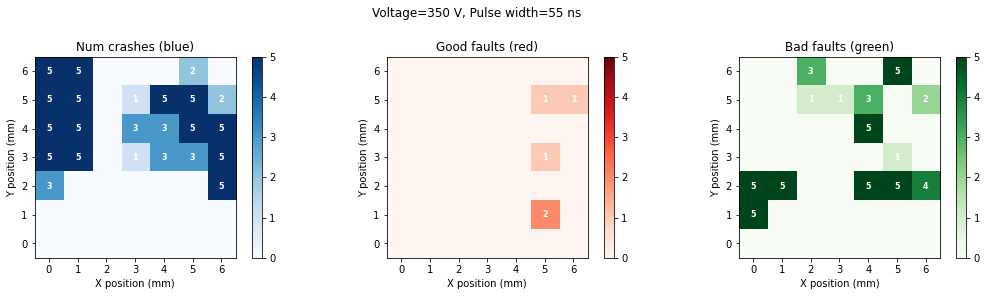

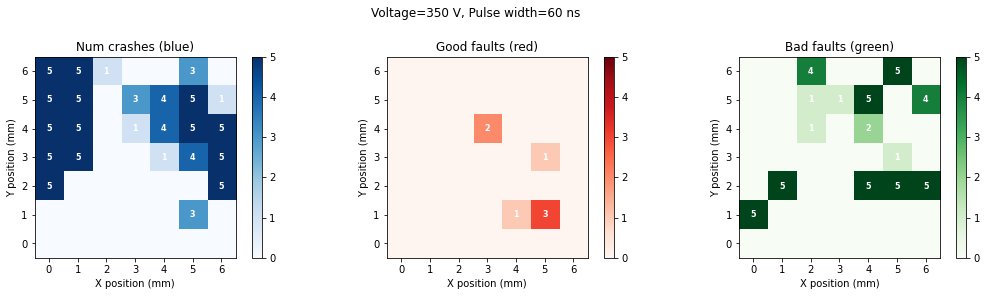

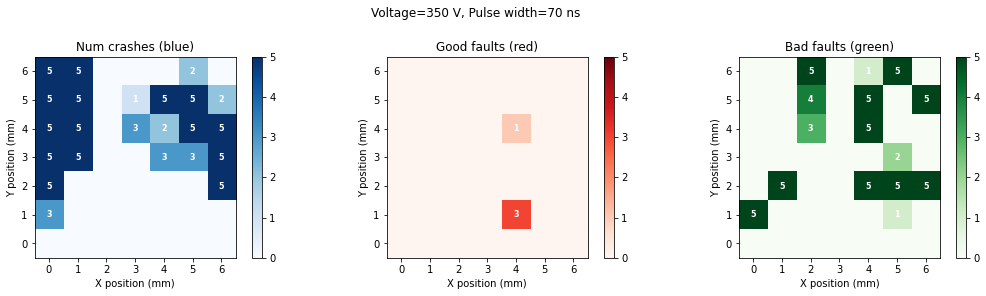

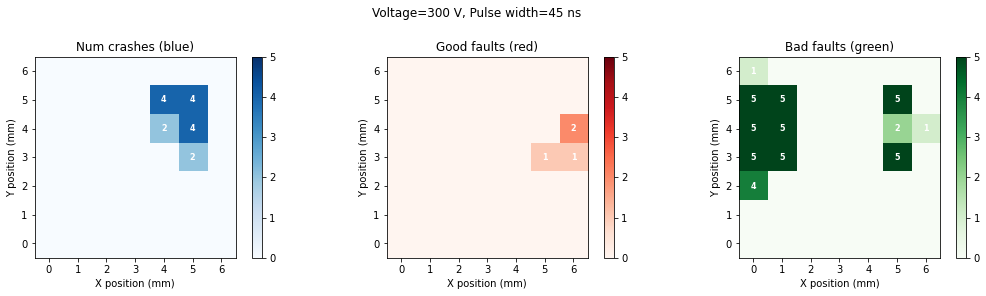

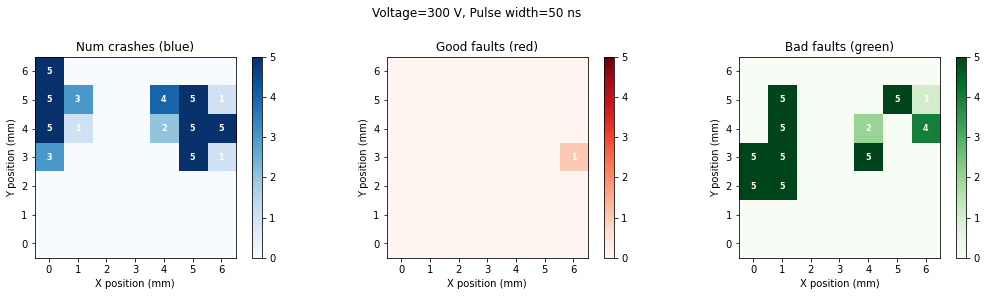

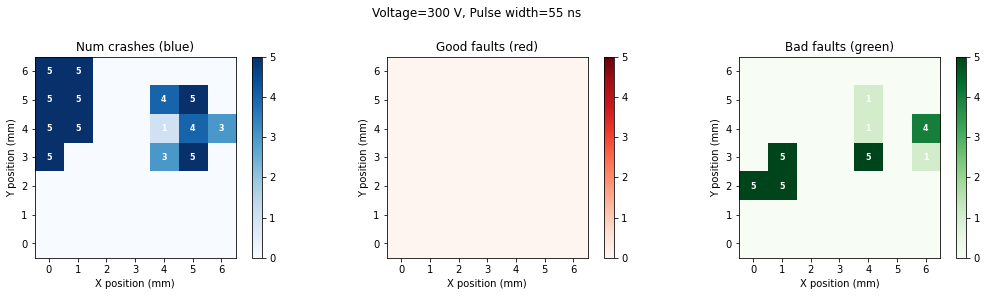

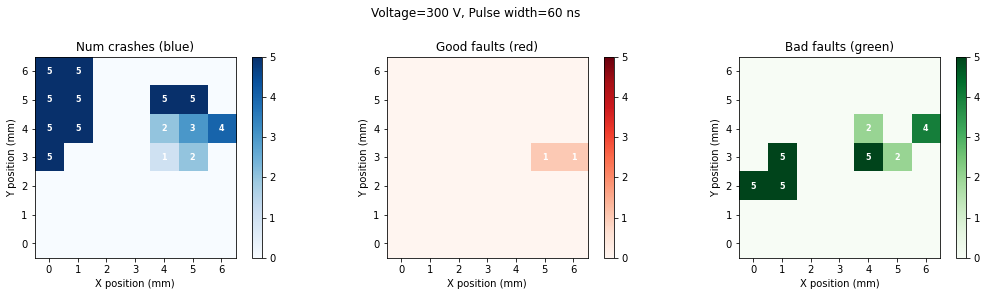

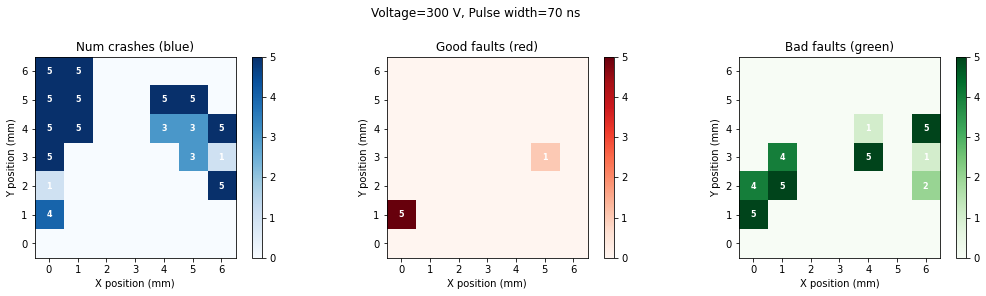

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import json
from collections import defaultdict

# -----------------------------
# Paths and origin
# -----------------------------
JSON_PATH = './results/results_profile-counter.json'
ORIGIN = np.array([25.075, 2.331, 15.59])

# -----------------------------
# Experiment parameter space
# -----------------------------
offsets = list(range(1000, 1140, 10))
voltages = [400, 350, 300]
pulse_widths = [45, 50, 55, 60, 70]

configs = []
for offset in offsets:
    for voltage in voltages:
        for pulse_width in pulse_widths:
            configs.append((offset, voltage, pulse_width))

# -----------------------------
# Load JSON data
# -----------------------------
with open(JSON_PATH, 'r') as f:
    data = json.load(f)

positions = np.array(data["positions"])
num_positions = len(positions)
print(num_positions)
shifted_positions = positions - ORIGIN
x = shifted_positions[:, 0]
y = shifted_positions[:, 1]

x_unique = np.unique(x)
y_unique = np.unique(y)
nx = len(x_unique)
ny = len(y_unique)

# -----------------------------
# Helper: extract good/bad faults
# -----------------------------
def extract_fault_counts(result_faults, num_positions):
    good_faults = np.zeros(num_positions, dtype=int)
    bad_faults  = np.zeros(num_positions, dtype=int)

    for entry in result_faults:
        pos = entry["position_index"]
        for d in entry["data"]:
            if d["counter"] == 99:
                good_faults[pos] += 1
            else:
                bad_faults[pos] += 1

    return good_faults, bad_faults

# -----------------------------
# Init heatmaps with zeroes
# -----------------------------
heatmaps = defaultdict(lambda: {
    "crashes":        np.zeros((ny, nx)),
    "good_faults":    np.zeros((ny, nx)),
    "bad_faults":     np.zeros((ny, nx)),
    "crash_idx":      np.full((ny, nx), -1, dtype=int),
    "good_idx":       np.full((ny, nx), -1, dtype=int),
    "bad_idx":        np.full((ny, nx), -1, dtype=int),
})

# -----------------------------
# Accumulate heatmaps (max per cell)
# -----------------------------
for cfg_idx, (offset, voltage, pulse_width) in enumerate(configs):
    cfg = data["glitch_configs"][cfg_idx]
    results = cfg["results"]

    crashes = np.array(results["num_crashes"])
    good_faults, bad_faults = extract_fault_counts(
        results.get("faults", []),
        num_positions
    )

    key = (voltage, pulse_width)

    for xi, yi, c, gf, bf in zip(x, y, crashes, good_faults, bad_faults):
        ix = np.where(x_unique == xi)[0][0]
        iy = np.where(y_unique == yi)[0][0]

        # Crashes
        if c > heatmaps[key]["crashes"][iy, ix]:
            heatmaps[key]["crashes"][iy, ix] = c
            heatmaps[key]["crash_idx"][iy, ix] = cfg_idx

        # Good faults
        if gf > heatmaps[key]["good_faults"][iy, ix]:
            heatmaps[key]["good_faults"][iy, ix] = gf
            heatmaps[key]["good_idx"][iy, ix] = cfg_idx

        # Bad faults
        if bf > heatmaps[key]["bad_faults"][iy, ix]:
            heatmaps[key]["bad_faults"][iy, ix] = bf
            heatmaps[key]["bad_idx"][iy, ix] = cfg_idx

# -----------------------------
# Plot side-by-side heatmaps with annotations
# -----------------------------
for (voltage, pulse_width), hm in heatmaps.items():
    fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharex=False, sharey=False)

    # Crashes
    im1 = axs[0].imshow(hm["crashes"], cmap="Blues", origin="lower", aspect="equal",
                        vmin=0, vmax=5)
    axs[0].set_title("Num crashes (blue)")
    for i in range(ny):
        for j in range(nx):
            val = hm["crashes"][i, j]
            if val > 0:
                axs[0].text(j, i, str(int(val)), ha="center", va="center",
                            color="white", fontsize=8, fontweight="bold")

    # Good faults
    im2 = axs[1].imshow(hm["good_faults"], cmap="Reds", origin="lower", aspect="equal",
                        vmin=0, vmax=5)
    axs[1].set_title("Good faults (red)")
    for i in range(ny):
        for j in range(nx):
            val = hm["good_faults"][i, j]
            if val > 0:
                axs[1].text(j, i, str(int(val)), ha="center", va="center",
                            color="white", fontsize=8, fontweight="bold")

    # Bad faults
    im3 = axs[2].imshow(hm["bad_faults"], cmap="Greens", origin="lower", aspect="equal",
                        vmin=0, vmax=5)
    axs[2].set_title("Bad faults (green)")
    for i in range(ny):
        for j in range(nx):
            val = hm["bad_faults"][i, j]
            if val > 0:
                axs[2].text(j, i, str(int(val)), ha="center", va="center",
                            color="white", fontsize=8, fontweight="bold")

    # Axes
    for ax in axs:
        ax.set_xlabel("X position (mm)")
        ax.set_ylabel("Y position (mm)")
        ax.set_xticks(np.arange(nx))
        ax.set_yticks(np.arange(ny))

    # Colorbars
    fig.colorbar(im1, ax=axs[0])
    fig.colorbar(im2, ax=axs[1])
    fig.colorbar(im3, ax=axs[2])

    # -----------------------------
    # Add subtitle with best config info for each metric
    # -----------------------------
    crash_pos_idx = np.unravel_index(hm["crashes"].argmax(), hm["crashes"].shape)
    good_pos_idx  = np.unravel_index(hm["good_faults"].argmax(), hm["good_faults"].shape)
    bad_pos_idx   = np.unravel_index(hm["bad_faults"].argmax(), hm["bad_faults"].shape)

    crash_cfg_idx = hm["crash_idx"][crash_pos_idx]
    good_cfg_idx  = hm["good_idx"][good_pos_idx]
    bad_cfg_idx   = hm["bad_idx"][bad_pos_idx]

    crash_cfg = configs[crash_cfg_idx] if crash_cfg_idx >= 0 else ("N/A",)
    good_cfg  = configs[good_cfg_idx]  if good_cfg_idx  >= 0 else ("N/A",)
    bad_cfg   = configs[bad_cfg_idx]   if bad_cfg_idx   >= 0 else ("N/A",)

    fig.suptitle(
        f"Voltage={voltage} V, Pulse width={pulse_width} ns\n"
    )

    plt.tight_layout()
    plt.show()


## Detail of optimal config (index 59)

49


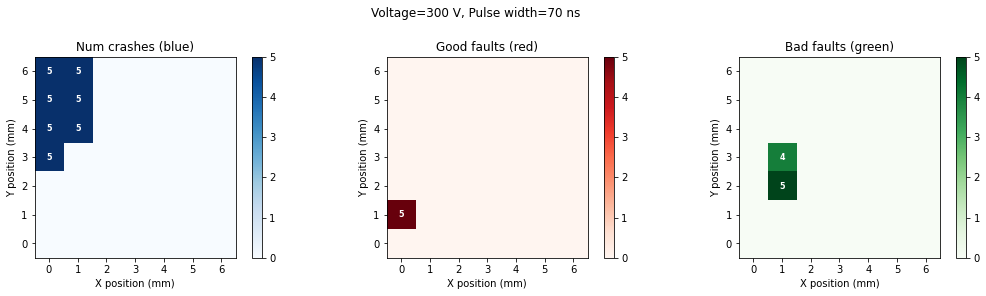

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import json

def extract_fault_counts(result_faults, num_positions):
    good_faults = np.zeros(num_positions, dtype=int)
    bad_faults  = np.zeros(num_positions, dtype=int)

    for entry in result_faults:
        pos = entry["position_index"]
        for d in entry["data"]:
            if d["counter"] == 99:
                good_faults[pos] += 1
            else:
                bad_faults[pos] += 1

    return good_faults, bad_faults

JSON_PATH = './results/results_profile-counter.json'
BG_PATH = "./results/image.png"
ORIGIN = np.array([25.075, 2.331, 15.59])

# TODO: make sure that orientation matches chip orientation reference
CONFIG_INDEX = 59
with open(JSON_PATH, 'r') as f:
    data = json.load(f)

positions = np.array(data["positions"])
num_positions = len(positions)
print(num_positions)
shifted_positions = positions - ORIGIN
x = shifted_positions[:, 0]
y = shifted_positions[:, 1]

x_unique = np.unique(x)
y_unique = np.unique(y)
nx = len(x_unique)
ny = len(y_unique)

crash_heatmap = np.zeros((ny, nx))
good_fault_heatmap= np.zeros((ny, nx))
bad_fault_heatmap = np.zeros((ny, nx))


cfg = data["glitch_configs"][CONFIG_INDEX]
results = cfg["results"]

crashes = np.array(results["num_crashes"])
good_faults, bad_faults = extract_fault_counts(
    results.get("faults", []),
    len(positions)
)

for xi, yi, c, gf, bf in zip(x, y, crashes, good_faults, bad_faults):
    ix = np.where(x_unique == xi)[0][0]
    iy = np.where(y_unique == yi)[0][0]

    crash_heatmap[iy, ix] = c
    good_fault_heatmap[iy, ix] = gf
    bad_fault_heatmap[iy, ix] = bf




fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharex=False, sharey=False)

# Crashes
im1 = axs[0].imshow(crash_heatmap, cmap="Blues", origin="lower", aspect="equal",
                    vmin=0, vmax=5)
axs[0].set_title("Num crashes (blue)")
for i in range(ny):
    for j in range(nx):
        val = crash_heatmap[i, j]
        if val > 0:
            axs[0].text(j, i, str(int(val)), ha="center", va="center",
                        color="white", fontsize=8, fontweight="bold")

# Good faults
im2 = axs[1].imshow(good_fault_heatmap, cmap="Reds", origin="lower", aspect="equal",
                    vmin=0, vmax=5)
axs[1].set_title("Good faults (red)")
for i in range(ny):
    for j in range(nx):
        val = good_fault_heatmap[i, j]
        if val > 0:
            axs[1].text(j, i, str(int(val)), ha="center", va="center",
                        color="white", fontsize=8, fontweight="bold")

# Bad faults
im3 = axs[2].imshow(bad_fault_heatmap, cmap="Greens", origin="lower", aspect="equal",
                    vmin=0, vmax=5)
axs[2].set_title("Bad faults (green)")
for i in range(ny):
    for j in range(nx):
        val = bad_fault_heatmap[i, j]
        if val > 0:
            axs[2].text(j, i, str(int(val)), ha="center", va="center",
                        color="white", fontsize=8, fontweight="bold")

# Axes
for ax in axs:
    ax.set_xlabel("X position (mm)")
    ax.set_ylabel("Y position (mm)")
    ax.set_xticks(np.arange(nx))
    ax.set_yticks(np.arange(ny))

# Colorbars
fig.colorbar(im1, ax=axs[0])
fig.colorbar(im2, ax=axs[1])
fig.colorbar(im3, ax=axs[2])

fig.suptitle(
    f"Voltage={voltage} V, Pulse width={pulse_width} ns\n"
)

plt.tight_layout()
plt.show()

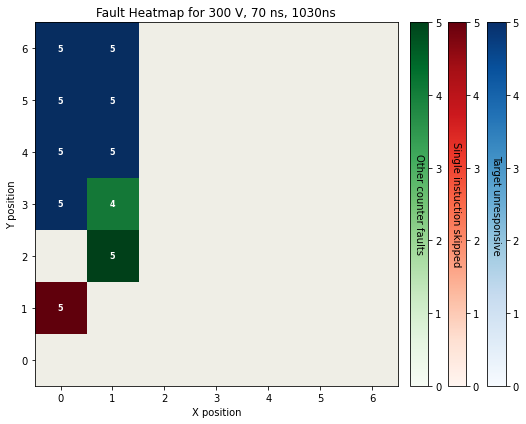

In [25]:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

# --- ASSUMING DATA IS LOADED ---
# crash_heatmap, good_fault_heatmap, bad_fault_heatmap are available

VMAX = 5.0

# 1. Get the Matplotlib Colormaps
cmap_c = plt.get_cmap('Blues')  # Crashes
cmap_g = plt.get_cmap('Reds')   # Good Faults
cmap_b = plt.get_cmap('Greens') # Bad Faults

# 2. Vectorized Image Generation (No for-loops)
# Normalize data to 0-1 range
norm_c = np.clip(crash_heatmap / VMAX, 0, 1)
norm_g = np.clip(good_fault_heatmap / VMAX, 0, 1)
norm_b = np.clip(bad_fault_heatmap / VMAX, 0, 1)

# Get RGBA arrays from colormaps -> Shape: (Height, Width, 4)
rgba_c = cmap_c(norm_c)
rgba_g = cmap_g(norm_g)
rgba_b = cmap_b(norm_b)

# 3. Multiply Blend (RGB only)
# We ignore the Alpha channel (index 3) and multiply the RGB channels (0-3)
# White is (1.0, 1.0, 1.0), so it acts as a neutral identity.
final_rgb = rgba_c[..., :3] * rgba_g[..., :3] * rgba_b[..., :3]

# --- 4. Plotting ---
fig, ax = plt.subplots(figsize=(10, 6))

im = ax.imshow(final_rgb, origin="lower", aspect="equal")

# Add text annotations
ny, nx = crash_heatmap.shape
for i in range(ny):
    for j in range(nx):
        total_val = crash_heatmap[i, j] + good_fault_heatmap[i, j] + bad_fault_heatmap[i, j]
        if total_val > 0:
            # Determine text color based on background brightness (luminance)
            # Standard formula for luminance: 0.299R + 0.587G + 0.114B
            pixel = final_rgb[i, j]
            lum = 0.299 * pixel[0] + 0.587 * pixel[1] + 0.114 * pixel[2]
            text_color = "white" if lum < 0.6 else "black"
            
            ax.text(j, i, str(int(total_val)), ha="center", va="center",
                    color=text_color, fontsize=8, fontweight="bold")

ax.set_title(f"Fault Heatmap for 300 V, 70 ns, 1030ns")
ax.set_xlabel("X position")
ax.set_ylabel("Y position")
ax.set_xticks(np.arange(nx))
ax.set_yticks(np.arange(ny))

# --- 5. Add Standard Colorbars ---
# We create ScalarMappables that point to the standard colormaps
norm = mcolors.Normalize(vmin=0, vmax=VMAX)

sm_c = cm.ScalarMappable(cmap=cmap_c, norm=norm)
sm_g = cm.ScalarMappable(cmap=cmap_g, norm=norm)
sm_b = cm.ScalarMappable(cmap=cmap_b, norm=norm)
# Initialize empty arrays so matplotlib doesn't complain
sm_c.set_array([])
sm_g.set_array([])
sm_b.set_array([])

# Add bars
cbar1 = fig.colorbar(sm_c, ax=ax, fraction=0.040, pad=0.02)
cbar1.set_label('Target unresponsive', rotation=270, labelpad=-18)

cbar2 = fig.colorbar(sm_g, ax=ax, fraction=0.040, pad=0.02)
cbar2.set_label('Single instuction skipped', rotation=270, labelpad=-18)

cbar3 = fig.colorbar(sm_b, ax=ax, fraction=0.040, pad=0.02)
cbar3.set_label('Other counter faults', rotation=270, labelpad=-18)

plt.tight_layout()
plt.show()